In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
fn_dem = "../data/renewables_with_load.parquet"
fn_ren = "../data/renewables_ninja.parquet"
COUNTRIES = ["FR", "DE", "GR"] 

## Get data

In [3]:
df_dem = (
    pd.read_parquet(
        fn_dem,
        filters=[("country", "in", COUNTRIES)],
        columns=["country", "dateTime", "demand"])
    .rename(columns={"dateTime": "date"})
)
df_ren = (
        pd.read_parquet(
        fn_ren,
        filters=[("country", "in", COUNTRIES),],
        columns=["country", "resource", "time", "total"])
        .rename(columns={"time": "date", "total": "capacity_factor"})
)
df_dem

,country,date,demand
0,FR,2014-12-15 09:00:00,72729.000
1,FR,2014-12-15 10:00:00,73107.000
2,FR,2014-12-15 11:00:00,73077.000
3,FR,2014-12-15 12:00:00,71859.000
4,FR,2014-12-15 13:00:00,70910.000
...,...,...,...
237870,GR,2024-01-14 12:00:00,5821.000
237871,DE,2024-01-14 13:00:00,55709.345
237872,FR,2024-01-14 13:00:00,70858.000
237873,GR,2024-01-14 13:00:00,5952.000


Create averages over the years (ignoring leap days).

In [4]:
df_dem_av = (
    df_dem
    .assign(
        month=lambda x: x.date.dt.month,
        day=lambda x: x.date.dt.day,
        hour=lambda x: x.date.dt.hour,
        year=lambda x: x.date.dt.year,
        leapday=lambda x: (x.date.dt.day == 29) & (x.date.dt.month == 2)
    )
    .query("not leapday")
    # exclude the first year for data reasons
    .groupby(["country", "month", "day", "hour"], as_index=False)
    ["demand"]
    .mean()
    .assign(date=lambda x: pd.to_datetime(
        x.day.astype("str").str.zfill(2) + "." 
        + x.month.astype("str").str.zfill(2) + ".2023 " 
        + x.hour.astype("str").str.zfill(2) + ":00",
        format="%d.%m.%Y %H:%M"
    ))
    .drop(columns=["month", "day", "hour"])
)
df_dem_av#.query(f"country == 'FR'").demand.plot()

,country,demand,date
0,DE,41998.17850,2023-01-01 00:00:00
1,DE,40722.92650,2023-01-01 01:00:00
2,DE,39749.69275,2023-01-01 02:00:00
3,DE,39394.25500,2023-01-01 03:00:00
4,DE,38966.65175,2023-01-01 04:00:00
...,...,...,...
26275,GR,6988.85700,2023-12-31 19:00:00
26276,GR,6139.54200,2023-12-31 20:00:00
26277,GR,5711.72200,2023-12-31 21:00:00
26278,GR,5347.49700,2023-12-31 22:00:00


In [5]:
df_dem_av = (
    df_dem
    .assign(
        month=lambda x: x.date.dt.month,
        day=lambda x: x.date.dt.day,
        hour=lambda x: x.date.dt.hour,
        year=lambda x: x.date.dt.year,
        leapday=lambda x: (x.date.dt.day == 29) & (x.date.dt.month == 2)
    )
    .query("not leapday")
    # exclude the first year for data reasons
    .query("year > 2015")
    .groupby(["country", "month", "day", "hour"], as_index=False)
    ["demand"]
    .mean()
    .assign(date=lambda x: pd.to_datetime(
        x.day.astype("str").str.zfill(2) + "." 
        + x.month.astype("str").str.zfill(2) + ".2023 " 
        + x.hour.astype("str").str.zfill(2) + ":00",
        format="%d.%m.%Y %H:%M"
    ))
    .drop(columns=["month", "day", "hour"])
)
df_ren_av = (
    df_ren
    .assign(
        month=lambda x: x.date.dt.month,
        day=lambda x: x.date.dt.day,
        hour=lambda x: x.date.dt.hour,
        leapday=lambda x: (x.date.dt.day == 29) & (x.date.dt.month == 2)
    )
    .query("not leapday")
    .groupby(["country", "resource", "month", "day", "hour"], as_index=False)
    ["capacity_factor"]
    .mean()
    .assign(date=lambda x: pd.to_datetime(
        x.day.astype("str").str.zfill(2) + "." 
        + x.month.astype("str").str.zfill(2) + ".2023 " 
        + x.hour.astype("str").str.zfill(2) + ":00",
        format="%d.%m.%Y %H:%M"
    ))
    .drop(columns=["month", "day", "hour"])
    .pivot_table(index=["date", "country"], columns="resource", values="capacity_factor")
    .reset_index()
)
df_av = pd.merge(df_dem_av, df_ren_av, on=["date", "country"], how="inner")
df_av.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   country  26280 non-null  object        
 1   demand   26280 non-null  float64       
 2   date     26280 non-null  datetime64[ns]
 3   pv       26280 non-null  float64       
 4   wind     26280 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.0+ MB


## Plots

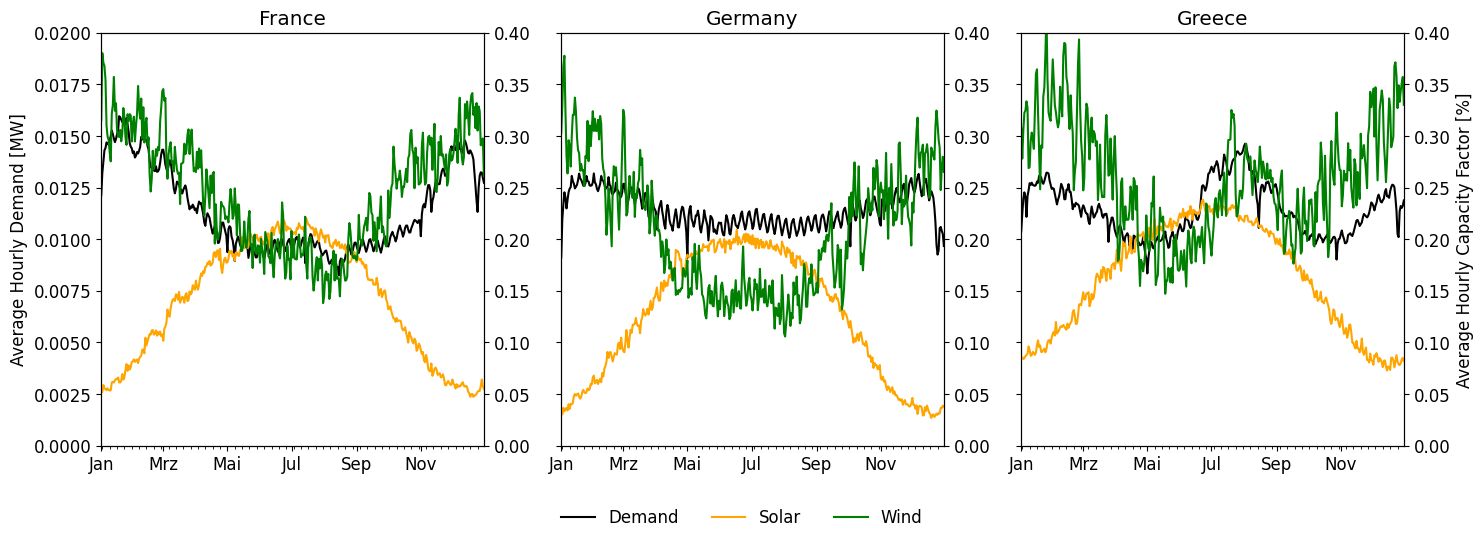

In [57]:
freq = "D"
annual_demand = 100

mpl.rcParams.update({'font.size': 12})
country_names = {
    "DE": "Germany",
    "FR": "France",
    "GR": "Greece",
}

lst_df = []
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))
for i, country in enumerate(COUNTRIES):
    ax = axs[i]
    df_p = (
        df_av.query(f"country == '{country}'") 
        .drop(columns="country")
        # convert demand to 100MW annual demand
        .assign(demand=lambda x: annual_demand * x.demand / x.demand.sum())
        .set_index("date")
        .resample(freq)
        .agg({
            "demand": "mean",
            "pv": "mean",
            "wind": "mean",
        })
    # 
    )
    
    df_p.demand.plot(label="Demand", ax=ax, color="k")
    ax.set_ylabel("Average Hourly Demand [MW]")
    ax.set_xlabel("")
    ax.set_ylim(0, 0.02)
    ax2 = ax.twinx()
    df_p["pv"].plot(ax=ax2, color="orange", label="Solar")
    df_p["wind"].plot(ax=ax2, color="green", label="Wind")
    ax2.set_ylim(0, .4)
    ax2.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,12,2)))
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    if i == len(COUNTRIES)-1:
        ax2.set_ylabel("Average Hourly Capacity Factor [%]")
    # combine the legends and put below the plot
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc='upper center')
    ax.set_title(country_names.get(country))



# combine the legends
lines, labels = ax.get_legend_handles_labels()[:3]
lines2, labels2 = ax2.get_legend_handles_labels()[:3]
lines = lines + lines2
labels = labels + labels2
# put legend below plot
fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), frameon=False)
plt.tight_layout()	

plt.savefig("../figures/demand_renewable_profile.png", dpi=300, bbox_inches="tight", )

## Decriptives

In [44]:
annual_demand = 100

country_names = {
    "DE": "Germany",
    "FR": "France",
    "GR": "Greece",
}
freq = "D"
lst_df = []
for i, country in enumerate(COUNTRIES):
    df_p = (
        df_av.query(f"country == '{country}'") 
        .drop(columns="country")
        # convert demand to 100MW annual demand
        .assign(demand=lambda x: annual_demand * x.demand / x.demand.sum())
        .set_index("date")
        .resample(freq)
        .agg({
            "demand": "mean",
            "pv": "mean",
            "wind": "mean",
        })
        .rename(columns={
            "demand": "Demand",
            "pv": "Solar",
            "wind": "Wind",
        })
    )
    df_ = (
        df_p.corr()
        .assign(
            Mean=lambda x: x.mean(),
            StandardDeviation=lambda x: x.std(),
            Country=country_names.get(country)
        )
    )
    lst_df.append(df_)
df_descriptive = pd.concat(lst_df).reset_index()[
    ["Country", "index", "Mean", "StandardDeviation", "Demand", "Solar", "Wind"]
    ].rename(columns={"StandardDeviation": "Standard Deviation"})

df_descriptive.to_excel("../figures/descriptive_statistics_daily.xlsx", index=False)
df_descriptive.round(2)


,Country,index,Mean,Standard Deviation,Demand,Solar,Wind
0,France,Demand,0.33,1.03,1.00,-0.85,0.85
1,France,Solar,-0.24,1.07,-0.85,1.00,-0.86
2,France,Wind,0.33,1.04,0.85,-0.86,1.00
3,Germany,Demand,0.33,0.88,1.00,-0.67,0.65
4,Germany,Solar,-0.18,1.03,-0.67,1.00,-0.88
5,Germany,Wind,0.26,1.00,0.65,-0.88,1.00
6,Greece,Demand,0.48,0.48,1.00,0.07,0.38
7,Greece,Solar,0.13,0.83,0.07,1.00,-0.66
8,Greece,Wind,0.24,0.84,0.38,-0.66,1.00


In [47]:
annual_demand = 100

country_names = {
    "DE": "Germany",
    "FR": "France",
    "GR": "Greece",
}
freq = "h"
lst_df = []
for i, country in enumerate(COUNTRIES):
    df_p = (
        df_av.query(f"country == '{country}'") 
        .drop(columns="country")
        # convert demand to 100MW annual demand
        .assign(demand=lambda x: annual_demand * x.demand / x.demand.sum())
        .set_index("date")
        .resample(freq)
        .agg({
            "demand": "mean",
            "pv": "mean",
            "wind": "mean",
        })
        .rename(columns={
            "demand": "Demand",
            "pv": "Solar",
            "wind": "Wind",
        })
    )
    df_ = (
        df_p.corr()
        .assign(
            Mean=lambda x: x.mean(),
            StandardDeviation=lambda x: x.std(),
            Country=country_names.get(country)
        )
    )
    lst_df.append(df_)
df_descriptive = pd.concat(lst_df).reset_index()[
    ["Country", "index", "Mean", "StandardDeviation", "Demand", "Solar", "Wind"]
    ].rename(columns={"StandardDeviation": "Standard Deviation"})
df_descriptive.to_excel("../figures/descriptive_statistics_hourly.xlsx", index=False)
df_descriptive

,Country,index,Mean,Standard Deviation,Demand,Solar,Wind
0,France,Demand,0.575374,0.520909,1.000000,-0.005877,0.732001
1,France,Solar,0.253577,0.656355,-0.005877,1.000000,-0.233393
2,France,Wind,0.499536,0.648725,0.732001,-0.233393,1.000000
3,Germany,Demand,0.597138,0.349811,1.000000,0.421091,0.370323
4,Germany,Solar,0.398434,0.613208,0.421091,1.000000,-0.225789
5,Germany,Wind,0.381511,0.612971,0.370323,-0.225789,1.000000
6,Greece,Demand,0.614179,0.335131,1.000000,0.447146,0.395392
7,Greece,Solar,0.533021,0.430514,0.447146,1.000000,0.151916
8,Greece,Wind,0.515769,0.436669,0.395392,0.151916,1.000000
